# Solar and reactor neutrino oscillations - JUNO exercise

Plot JUNO expected spectrum after 6 years of data taking, for both mass orderings.

Change energy resolution and see what happens.

Change baseline and see what happens.

**Note:** this notebook makes use of the ORSA package, which is currently not available to public.

In [1]:
import pickle
import json
import orsa
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.stats import multivariate_normal, norm
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import copy
import matplotlib as mpl
import pkg_resources
pd.options.mode.chained_assignment = None 
import matplotlib.gridspec as gridspec
import time


sns.set(style = 'white')
mpl.rc('xtick.minor', visible = False)
mpl.rc('ytick.minor', visible = True)
mpl.rc('xtick', direction='in', top=True, bottom = True)
mpl.rc('ytick', direction='in', right=True, left = True)
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams['figure.constrained_layout.use'] = True

print(orsa.__version__)

savefig = False

Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:
CUDA not installed! Falling back to CPU
0.5.6


In [2]:
labels = [
    'osc_dm2_21',
    'osc_dm2_31',
    'osc_s2_12',
    'osc_s2_13',
    'N_rea']

nice_labels = dict(
    res_eff = r'eff', res_a = r'$a$', res_b = r'$b$', res_c = r'$c$', 
    res_a0 = r'$a_0$', res_a1 = r'$a_1$', res_a2 = r'$a_2$', res_a3 = r'$a_3$', 
    osc_rho = r'$\rho$', osc_dm2_21=r'$\Delta m^2_{21}$', osc_dm2_31=r'$\Delta m^2_{31}$',
    osc_s2_13 = r'$\sin^2 \theta_{13}$', osc_s2_12=r'$\sin^2 \theta_{12}$', 
    N_rea = r'$N_\mathrm{rea}$')


## Create spectrum

In [3]:
# Initialize detector response and oscillation probability to the default values
osc0 = orsa.oscillation.default()
res0 = orsa.detector.default()
res0.non_linearity_model = 'common_input'

# Specify the extremes and the binning to use for creating the model
E_bin = 1e-2 #10 KeV
E_left = 0.5
E_right = 13.
E_eval = np.arange(E_left+E_bin/2., E_right+E_bin/2., E_bin)

# Specify the extremes to use for the fit
E_min = 0.8
E_max = 12.

isPDF=False


(0.0, 0.003247009739041408)

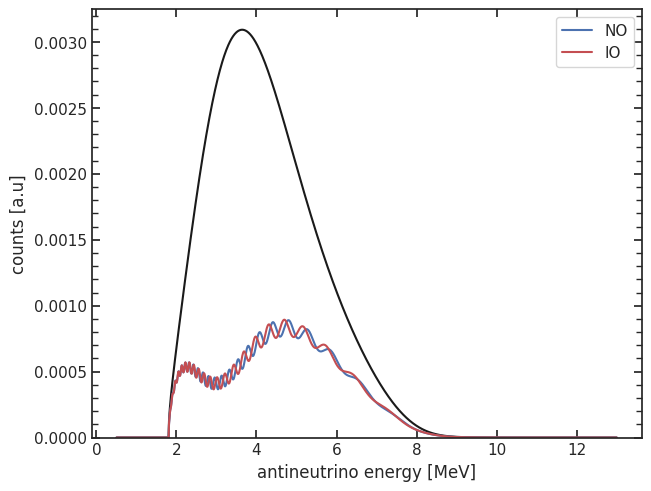

In [4]:
# sp_rea = orsa.generator.sniper('reactors', isPDF=isPDF)
sp_rea = orsa.generator.reactor(isPDF, True)
rate_day = 47.1
years = 6
N_rea = rate_day * 365.25 * years * 11/12. 

sp_rea_eval = sp_rea.get_spectrum(E_eval)
osc0.ordering = "NO"
sp_rea_osc_NO = osc0.oscillate(sp_rea_eval, matter=False)
osc0.ordering = "IO"
sp_rea_osc_IO = osc0.oscillate(sp_rea_eval, matter=False)

fig, ax = plt.subplots(1, 1, constrained_layout=True)
ax.plot(sp_rea_eval.E, sp_rea_eval.counts, c="k")
ax.plot(sp_rea_osc_NO.E, sp_rea_osc_NO.counts, label="NO", c="b")
ax.plot(sp_rea_osc_IO.E, sp_rea_osc_IO.counts, label="IO", c="r")

ax.legend()
ax.set_xlabel("antineutrino energy [MeV]")
ax.set_ylabel("counts [a.u]")
ax.set_ylim(bottom=0)

## Study MO resolving power as function of energy resolution

In [5]:
sp_rea_dep_NO = res0.to_dep(sp_rea_osc_NO)
sp_rea_dep_IO = res0.to_dep(sp_rea_osc_IO)

sp_rea_vis_NO = res0.to_vis(sp_rea_dep_NO)
sp_rea_vis_IO = res0.to_vis(sp_rea_dep_IO)

sp_rea_vis_NO = sp_rea_vis_NO.resample(E_eval).norm(N_rea, E_min, E_max)
sp_rea_vis_IO = sp_rea_vis_IO.resample(E_eval).norm(N_rea, E_min, E_max)

In [6]:
a_list = [0.03, 0.05]
NO_list = [sp_rea_vis_NO]
IO_list = [sp_rea_vis_IO]

res0.b = 0
res0.c = 0
for a in a_list:
    res0.a = a
    temp = res0.to_rec(sp_rea_vis_NO)
    NO_list.append(temp.resample(E_eval).norm(N_rea, E_min, E_max))
    temp = res0.to_rec(sp_rea_vis_IO)
    IO_list.append(temp.resample(E_eval).norm(N_rea, E_min, E_max))

Text(0.5, 0.98, 'baseline = 52.5 km - 6 years')

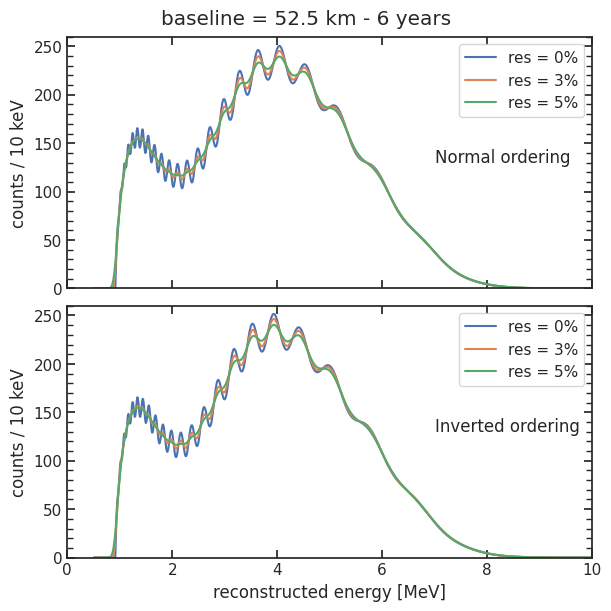

In [7]:
labels = ["0%", "3%", "5%"]

fig, axes = plt.subplots(2, 1, constrained_layout=True, figsize=[6,6], sharex=True)
for ii, sp in enumerate(NO_list):
    axes[0].plot(sp.E, sp.counts, label=f"res = {labels[ii]}")
    axes[1].plot(IO_list[ii].E, IO_list[ii].counts, label=f"res = {labels[ii]}")

titles = ["Normal ordering", "Inverted ordering"]
for ii, ax in enumerate(axes):
    ax.legend()
    ax.set_ylim(bottom=0, top=260)
    ax.set_ylabel("counts / 10 keV")
    ax.text(0.7, 0.5, titles[ii], transform=ax.transAxes)

axes[1].set_xlabel("reconstructed energy [MeV]")
axes[1].set_xlim(left=0, right=10)

fig.suptitle("baseline = 52.5 km - 6 years")

Text(0.5, 0.98, 'baseline = 52.5 km - 6 years')

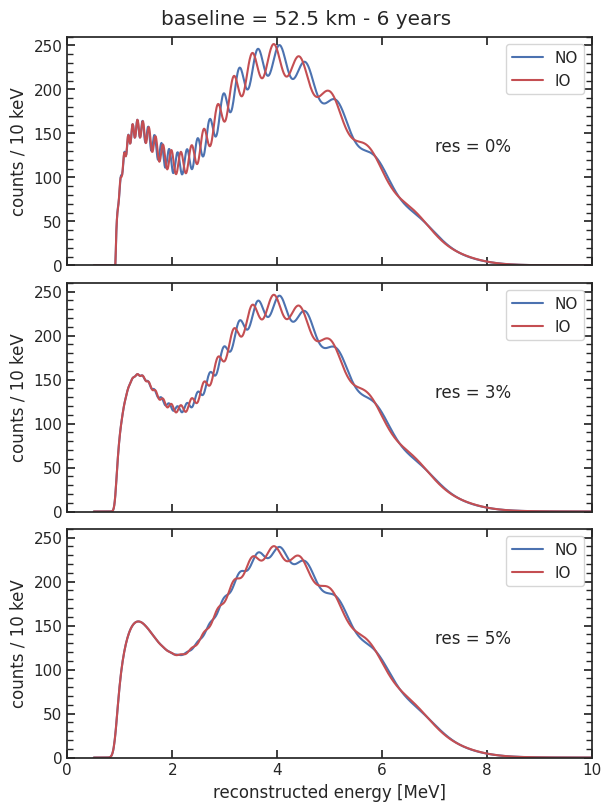

In [8]:
fig, axes = plt.subplots(3, 1, constrained_layout=True, sharex=True, figsize=[6,8])

for ii, a in enumerate(NO_list):
    axes[ii].plot(NO_list[ii].E, NO_list[ii].counts, label="NO", c="b")
    axes[ii].plot(IO_list[ii].E, IO_list[ii].counts, label="IO", c="r")

for ii, ax in enumerate(axes):
    ax.legend()
    ax.set_ylabel("counts / 10 keV")
    ax.set_ylim(bottom=0, top=260)
    ax.set_xlim(right=10, left=0)
    text = f"res = {labels[ii]}"
    ax.text(0.7, 0.5, text, transform=ax.transAxes)

axes[-1].set_xlabel("reconstructed energy [MeV]")

fig.suptitle("baseline = 52.5 km - 6 years")

## Study MO resolving power as function of baseline

note: the neutrino fluxes evolve as baseline^-2, so at longer baselines, we will have a lower flux, hence lower statistics

changing the baseline, the daily reactor nu rata of 47.1 is no longer true

In [9]:
baselines = [52.5, 75]

NO_list = []
IO_list = []
NO_list_res = []
IO_list_res = []
sp_rea_eval = sp_rea.get_spectrum(E_eval)
res0.a = 0.03
for bsl in baselines:
    osc0.baseline = bsl
    osc0.ordering = "NO"
    temp = osc0.oscillate(sp_rea_eval, matter=False)
    temp = res0.to_dep(temp)
    temp = res0.to_vis(temp)
    temp2 = temp.resample(E_eval).norm(N_rea, E_min, E_max)
    NO_list.append(temp2)
    temp = res0.to_rec(temp)
    temp2 = temp.resample(E_eval).norm(N_rea, E_min, E_max)
    NO_list_res.append(temp2)

    osc0.ordering = "IO"
    temp = osc0.oscillate(sp_rea_eval, matter=False)
    temp = res0.to_dep(temp)
    temp = res0.to_vis(temp)
    temp2 = temp.resample(E_eval).norm(N_rea, E_min, E_max)
    IO_list.append(temp2)
    temp = res0.to_rec(temp)
    temp2 = temp.resample(E_eval).norm(N_rea, E_min, E_max)
    IO_list_res.append(temp2)

Text(0.5, 0.98, 'With perfect resolution')

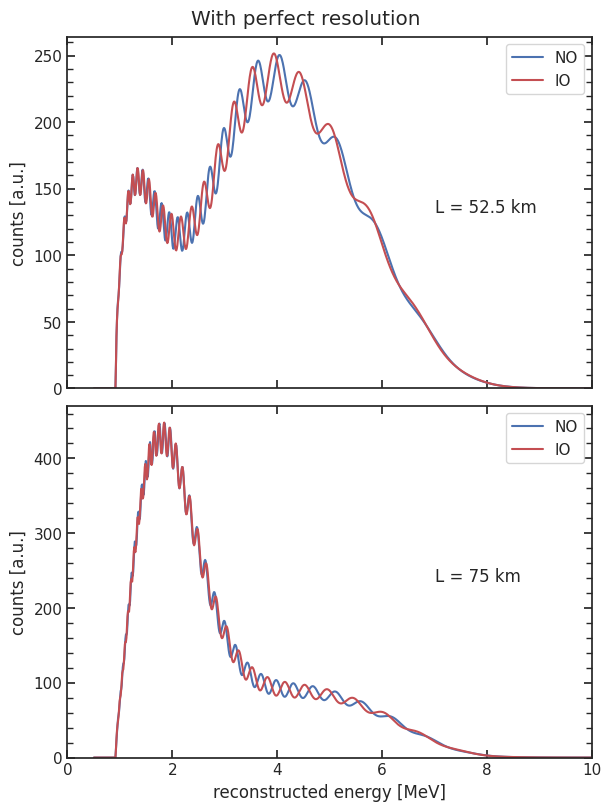

In [17]:
fig, axes = plt.subplots(2, 1, constrained_layout=True, sharex=True, figsize=[6,8])

for ii, bsl in enumerate(baselines):
    axes[ii].plot(NO_list[ii].E, NO_list[ii].counts, label="NO", c="b")
    axes[ii].plot(IO_list[ii].E, IO_list[ii].counts, label="IO", c="r")

for ii, ax in enumerate(axes):
    ax.legend()
    ax.set_ylabel("counts [a.u.]")
    ax.set_ylim(bottom=0)
    ax.set_xlim(right=10, left=0)
    text = f"L = {baselines[ii]} km"
    ax.text(0.7, 0.5, text, transform=ax.transAxes)

axes[-1].set_xlabel("reconstructed energy [MeV]")

fig.suptitle("With perfect resolution")

Text(0.5, 0.98, 'With 3% resolution')

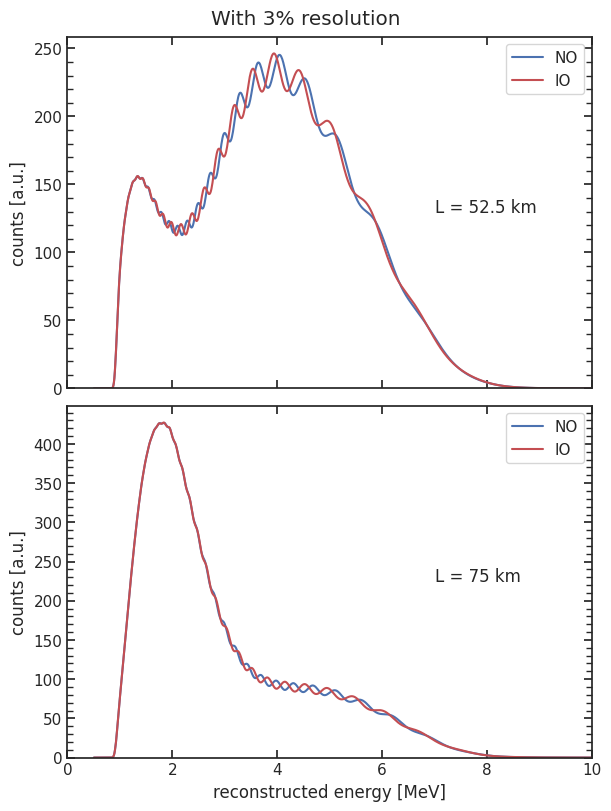

In [11]:
fig, axes = plt.subplots(2, 1, constrained_layout=True, sharex=True, figsize=[6,8])

for ii, bsl in enumerate(baselines):
    axes[ii].plot(NO_list_res[ii].E, NO_list_res[ii].counts, label="NO", c="b")
    axes[ii].plot(IO_list_res[ii].E, IO_list_res[ii].counts, label="IO", c="r")

for ii, ax in enumerate(axes):
    ax.legend()
    ax.set_ylabel("counts [a.u.]")
    ax.set_ylim(bottom=0)
    ax.set_xlim(right=10, left=0)
    text = f"L = {baselines[ii]} km"
    ax.text(0.7, 0.5, text, transform=ax.transAxes)

axes[-1].set_xlabel("reconstructed energy [MeV]")

fig.suptitle("With 3% resolution")

## Plot survival probability in vacuum

Text(0.5, 1.0, 'baseline = 52.5 km')

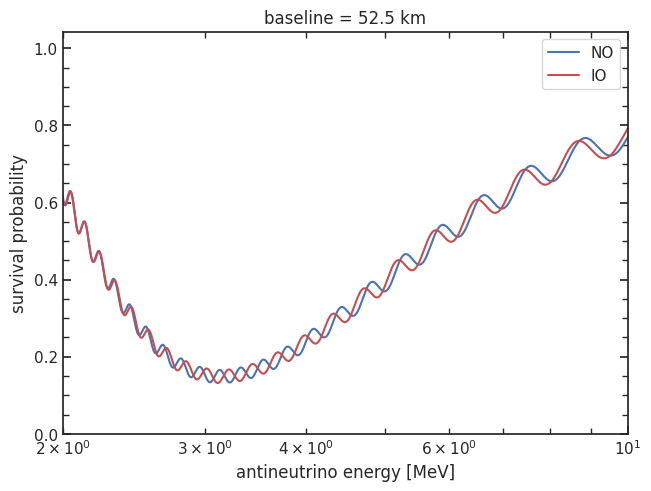

In [12]:
nu_energy = np.arange(0.0001, 1000, 0.001)

osc0.baseline = 52.5

osc0.ordering = "NO"
prob_NO = osc0.eval_vacuum_prob(nu_energy)

osc0.ordering = "IO"
prob_IO = osc0.eval_vacuum_prob(nu_energy)

fig, ax = plt.subplots(1, 1, constrained_layout=True)
ax.plot(nu_energy, prob_NO, label="NO", c="b")
ax.plot(nu_energy, prob_IO, label="IO", c="r")

ax.legend()
ax.set_xlabel("antineutrino energy [MeV]")
ax.set_ylabel("survival probability")
ax.set_ylim(bottom=0)
ax.set_xlim(left=5.e-1)
ax.semilogx()
ax.set_xlim(left=2, right=10)
ax.set_title(f"baseline = {osc0.baseline} km")

Text(0.5, 1.0, 'baseline = 75 km')

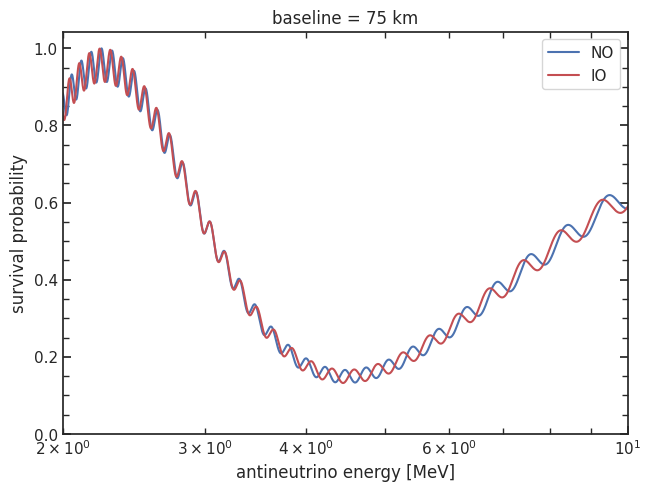

In [13]:
nu_energy = np.arange(0.0001, 1000, 0.001)

osc0.baseline = 75

osc0.ordering = "NO"
prob_NO = osc0.eval_vacuum_prob(nu_energy)

osc0.ordering = "IO"
prob_IO = osc0.eval_vacuum_prob(nu_energy)

fig, ax = plt.subplots(1, 1, constrained_layout=True)
ax.plot(nu_energy, prob_NO, label="NO", c="b")
ax.plot(nu_energy, prob_IO, label="IO", c="r")

ax.legend()
ax.set_xlabel("antineutrino energy [MeV]")
ax.set_ylabel("survival probability")
ax.set_ylim(bottom=0)
ax.set_xlim(left=5.e-1)
ax.semilogx()
ax.set_xlim(left=2, right=10)
ax.set_title(f"baseline = {osc0.baseline} km")

In [14]:
bsl1 = 52.5
bsl2 = 75

s1 = 1 / bsl1**2
s2 = 1 / bsl2**2

s1, s2, s2/s1

(0.00036281179138321996, 0.00017777777777777779, 0.49)

[]

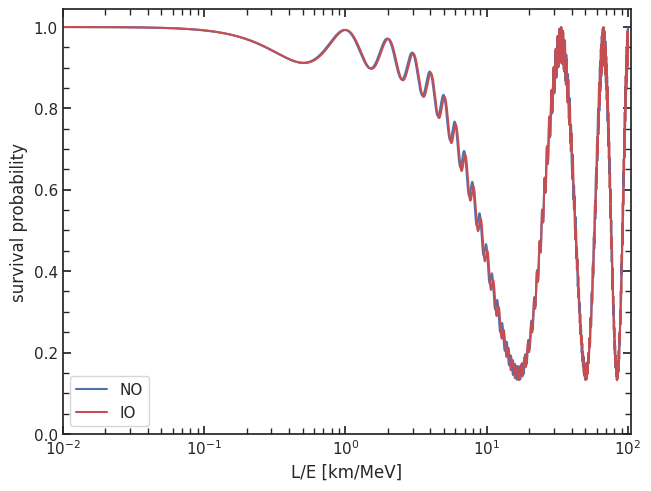

In [15]:
L_over_E = np.concatenate((
    np.arange(1e-2, 1., 0.01),
    np.arange(1., 1e5, 1)
    ))

osc0.baseline = 52.5

osc0.ordering = "NO"
prob_NO = osc0.eval_vacuum_prob(L_over_E, nu_energy_=False)

osc0.ordering = "IO"
prob_IO = osc0.eval_vacuum_prob(L_over_E, nu_energy_=False)

fig, ax = plt.subplots(1, 1, constrained_layout=True)
ax.plot(L_over_E/1000, prob_NO, label="NO", c="b")
ax.plot(L_over_E/1000, prob_IO, label="IO", c="r")

ax.legend()
ax.set_xlabel("L/E [km/MeV]")
ax.set_ylabel("survival probability")
ax.set_ylim(bottom=0)
ax.set_xlim(left=1.e-2)
ax.semilogx()

[]

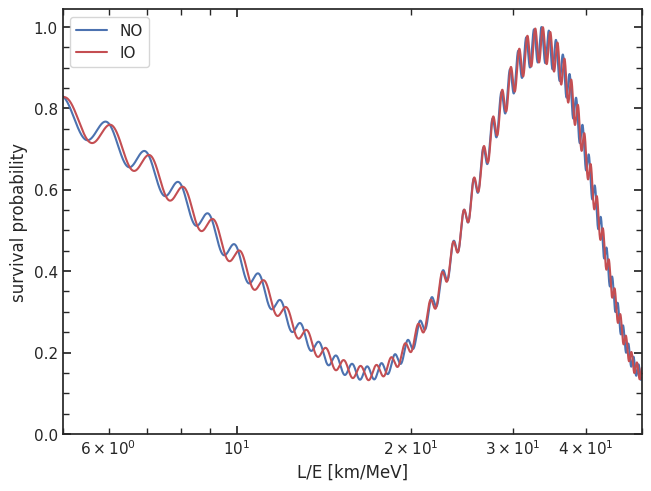

In [16]:
fig, ax = plt.subplots(1, 1, constrained_layout=True)
ax.plot(L_over_E/1000, prob_NO, label="NO", c="b")
ax.plot(L_over_E/1000, prob_IO, label="IO", c="r")

ax.legend()
ax.set_xlabel("L/E [km/MeV]")
ax.set_ylabel("survival probability")
ax.set_ylim(bottom=0)
ax.set_xlim(left=5., right=50)
ax.semilogx()